# t-Stochastic Neighbor Embedding (t-SNE)
Reference paper: TODO https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

## Introduction
t-SNE is a non-linear dimension reduction technique. This is usefull for visualizing high dimensional data.

TODO add example

## Other approches
- Chernoff faces
- PCA

Lets define $p_{j|i}$ as the probability that we pick $x_j$ if we choose the points with probability proportional to a gaussian centered at $x_i$.

More formally if we choose a gaussian of variance $\sigma_i$:
$$\forall i, \forall j \neq i, p_{j|i}=\frac{\exp\left(-\frac{||x_i-x_j||}{2\sigma_i^2}\right)}{\sum_{k\neq i}\exp\left(-\frac{||x_i-x_k||}{2\sigma_i^2}\right)}$$
$$\forall i, p_{i|i}=0$$
Note that the denominator is just here for the normalization constraint:
$$\sum_{j}p_{j|i}=1$$

Just as we just did for the $x_i$, we can define $q_{j|i}$ for the $y_i$.

To measure how faithfully $q_{j|i}$ models $p_{j|i}$, we define the Kullback-Leibler divergence:
$$C=\sum_{i,j}p_{j|i}\log{\frac{p_{j|i}}{q_{j|i}}}$$
By the properties of morphims of the logarithm, this just is the cross entropy up to an additive constant.
$$C=-\sum_{i,j}p_{j|i}\log{q_{j|i}} + \text{ cst}$$

The gradient is:
$$\frac{\delta C}{\delta y_i}=2\sum_j(p_{j|i}-q_{j|i}+p_{i|j}-q_{i|j})(y_i-y_j)$$

Symetric:
$$p_{ij}=\frac{p_{j|i}+p_{i|j}}{2n}$$

Gradient for symetric SNE:
$$\frac{\delta C}{\delta y_i}=4\sum_j(p_{ij}-q{ij})(y_i-y_j)$$

To prevent crowding:
$$q_{ij}=\frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\neq l}(1+||y_k-y_l||^2)^{-1}}$$

The gradient now becomes:
$$\frac{\delta C}{\delta y_i}=4\sum_j(p_{ij}-q_{ij})(y_i-y_j)(1+||y_i-y_j||^2)^{-1}$$

## Algorithm outline

### Input

- data set $\mathcal{X}=\{x_1, \dots, x_n\}$
- optimization parameters: number of iterations $T$, learning rate $\eta$, momemtum $\alpha(t)$
- cost function parameters: perplexity $Per p$

### Output

low dimentional representation of the data: $\mathcal{Y}^{(T)}=\{y_1, \dots, y_n\}$

### Initialization

- compute $p_{j|i}$ and $p_{ij}$
- choose an initial solution $\mathcal{Y}^{(0)}=\{y_1, \dots, y_n\}$

### For $t=1$ to $T$

- compute $q_{ij}$
- compute the gradient
- set $\mathcal{Y}^{(t)}:=\mathcal{Y}^{(t-1)}+\eta\frac{\delta C}{\delta \mathcal{Y}}+\alpha(t)\left(\mathcal{Y}^{(t-1)}-\mathcal{Y}^{(t-2)}\right)$

## Imports

In [1]:
%matplotlib notebook
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from math import ceil, sqrt, sin, exp

## Toy data generation

<IPython.core.display.Javascript object>


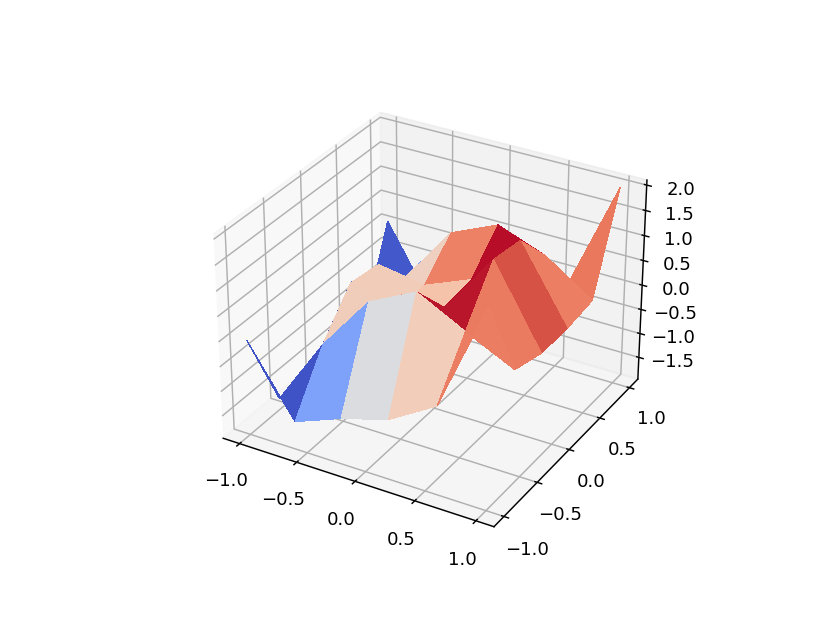

In [8]:
# Parameters.
n = 30
sigma_noise = 0.05

# Make sure that n is a square.
sqrt_n = ceil(sqrt(n))
n = sqrt_n ** 2

# Sample the manifold.
xs = np.linspace(-1, 1, sqrt_n)
ys = np.linspace(-1, 1, sqrt_n)
xs, ys = np.meshgrid(xs, ys)
zs = xs + np.sin(4 * (xs ** 2 + ys ** 2))

X = np.array([xs.flatten(), ys.flatten(), zs.flatten()]).T

# Add noise.
zs += sigma_noise * np.random.randn(*zs.shape)

# Show the generated data.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(xs, ys, zs, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

## Learning parameters

In [3]:
T = 10
eta = .3
alpha = 0 * np.ones(n)  # Constant for now.
per = 1

## Compute $p_{j|i}$

In [4]:
sigma = np.ones(n)  # TODO

a = np.arange(0, n - 1)
p = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            p[i][j] = exp(-(np.linalg.norm(X[i] - X[j]) ** 2 / (2 * sigma[i] ** 2)))
    # Normalize.
    p[i] /= np.sum(p[i])

## Compute $p_{ij}$

In [5]:
P = (p + p.T) / (2 * n)

## Initial solution

In [6]:
Y = np.random.rand(n, 2)
Y_old = np.copy(Y)

## Main loop

### For $t=1$ to $T$

- compute $q_{ij}$
- compute the gradient
- set $\mathcal{Y}^{(t)}:=\mathcal{Y}^{(t-1)}+\eta\frac{\delta C}{\delta \mathcal{Y}}+\alpha(t)\left(\mathcal{Y}^{(t-1)}-\mathcal{Y}^{(t-2)}\right)$



To prevent crowding:
$$q_{ij}=\frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\neq l}(1+||y_k-y_l||^2)^{-1}}$$

The gradient now becomes:
$$\frac{\delta C}{\delta y_i}=4\sum_j(p_{ij}-q_{ij})(y_i-y_j)(1+||y_i-y_j||^2)^{-1}$$

The cost is:
$$C=\sum_{i,j}p_{j|i}\log{\frac{p_{j|i}}{q_{j|i}}}$$


<IPython.core.display.Javascript object>


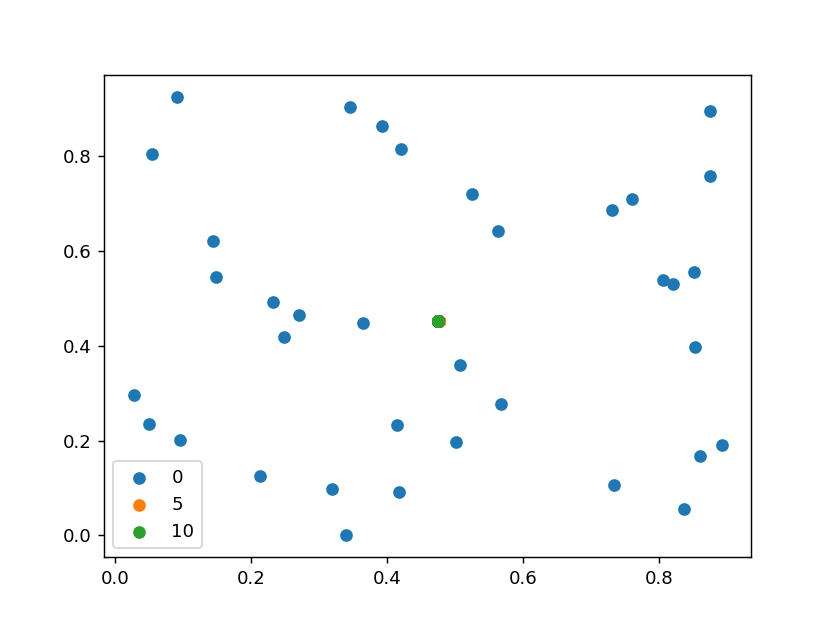

<ipython-input-7-2ac9367dd0ac>:18: RuntimeWarning: divide by zero encountered in log
  cost = np.sum(P * np.maximum(np.log(P / (np.maximum(Q, 10 ** (-11)))), -10 ** 63))


Iteration 0/10: -3.2618532746132303
Iteration 1/10: -3.2818141321482206
Iteration 2/10: -3.282667536552529
Iteration 3/10: -3.2826799346705062
Iteration 4/10: -3.2826803323976677
Iteration 5/10: -3.2826803445271966
Iteration 6/10: -3.282680344852593
Iteration 7/10: -3.2826803448587762
Iteration 8/10: -3.282680344858732
Iteration 9/10: -3.282680344858714
[[0.4757585  0.45328459]
 [0.47575849 0.45328459]
 [0.47575851 0.45328456]
 [0.4757585  0.45328453]
 [0.4757585  0.45328457]
 [0.47575849 0.45328462]
 [0.47575849 0.45328454]
 [0.47575844 0.4532846 ]
 [0.47575851 0.45328454]
 [0.47575849 0.45328462]
 [0.47575848 0.45328455]
 [0.47575847 0.45328459]
 [0.47575851 0.45328458]
 [0.47575844 0.45328461]
 [0.47575845 0.45328455]
 [0.47575847 0.45328456]
 [0.47575845 0.45328456]
 [0.47575844 0.45328457]
 [0.47575852 0.4532846 ]
 [0.47575848 0.45328458]
 [0.47575845 0.4532846 ]
 [0.47575845 0.45328457]
 [0.47575851 0.4532846 ]
 [0.47575845 0.45328462]
 [0.47575849 0.45328462]
 [0.47575844 0.4532

In [7]:
# Training loop.
for t in range(T):
    if t % 5 == 0:
        # Plot the actual result.
        plt.scatter(Y[:, 0], Y[:, 1], label=f'{t}')
    
    # Compute q_{ij}.
    a = np.arange(0, n - 1)
    Q = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                Q[i][j] = 1 / (1 + np.linalg.norm(Y[i] - Y[j]) ** 2)
        # Normalize.
        Q[i] /= np.sum(Q[i])

    # Print the cost.
    cost = np.sum(P * np.maximum(np.log(P / (np.maximum(Q, 10 ** (-11)))), -10 ** 63))
    print(f'Iteration {t}/{T}: {cost}')
    
    # Compute de gradient.
    gradient = np.array(
        [4 * sum(
            (P[i, j] - Q[i, j]) * (Y[i] - Y[j]) / (1 + np.linalg.norm(Y[i] - Y[j]) ** 2)
                 for j in range(n))
         for i in range(n)])
    
    # Update Y and Y_old.
    Y, Y_old = Y + eta * gradient + alpha[t] * (Y - Y_old), Y

print(Y)
plt.scatter(Y[:, 0], Y[:, 1], label=f'{T}')
plt.legend()
plt.show()

## Application to the MNIST dataset